# **Natural Language Processing with Disaster Tweets ⛈**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Proin semper, sem ut pulvinar pulvinar, est leo pretium sem, vel varius erat orci quis turpis. Aliquam augue orci, semper at mi vel, auctor fermentum ipsum. Nulla hendrerit hendrerit consequat. Vestibulum interdum, dolor id ultricies hendrerit, leo purus dignissim mauris, sit amet maximus nunc mauris eu mi. Quisque hendrerit ante eget pharetra iaculis. Nunc ullamcorper ante quam, non laoreet urna cursus eget. In hac habitasse platea dictumst. Donec ac risus consectetur, euismod magna sit amet, elementum justo. Sed non nisl lacinia, gravida odio ac, vehicula felis. Morbi non accumsan diam. Aenean nibh nunc, pulvinar quis vestibulum ac, tincidunt efficitur nibh. Maecenas vitae molestie leo. Pellentesque varius at felis vitae tristique. Nunc rutrum nisl sagittis velit finibus congue.

**Authors:**
- [Andrea Ramirez](https://github.com/Andrea-gt)
- [Adrian Flores](https://github.com/adrianRFlores)

***

## **(1) Import Libraries** ⬇️

In [1]:
#!pip install unidecode

In [37]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew, probplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from unidecode import unidecode

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

## **(2) Data Upload** 📄

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **(3) Exploratory Analysis** 🔎

### **(1) Descripción General de los Datos**

In [4]:
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 7613 registers and 5 columns.


**Observaciones 💡 -->**

> - El conjunto de datos original cuenta con 7613 registros y 5 columnas, lo que indica que tiene una dimensión relativamente pequeña. Cada uno de los 7613 registros representa una observación única, mientras que las 5 columnas corresponden a diferentes características o variables medidas para cada observación, incluyendo el texto de un tweet, una palabra clave asociada y la ubicación desde donde se envió, aunque estas últimas dos pueden estar en blanco en algunas ocasiones.

**Fuente:** [Página oficial de Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv)

In [5]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Como se puede observar, se cuentan con 5 columnas o features en este conjunto de datos, siendo estas las que se describen a continuación.

- **id**: un identificador único para cada tweet.
- **text**: el texto del tweet.
- **location**: la ubicación desde donde se envió el tweet (puede estar en blanco).
- **keyword**: una palabra clave particular del tweet (puede estar en blanco).
- **target**: en el archivo `train.csv` solamente, indica si un tweet es sobre un desastre real (`1`) o no (`0`).

### **(2) Clasificación de las Variables**

| **Nombre**    | **Descripción**                                             | **Tipo de variable**                     |
|---------------|-------------------------------------------------------------|------------------------------------------|
| **id**        | Un identificador único para cada tweet                      | Cuantitativa                             |
| **text**      | El texto del tweet                                          | Cualitativa (descriptiva)                |
| **location**  | La ubicación desde donde se envió el tweet                  | Cualitativa (descriptiva)                |
| **keyword**   | Una palabra clave particular del tweet                      | Cualitativa (descriptiva)                |
| **target**    | Indica si un tweet es sobre un desastre real o no           | Cualitativa (binaria)                    |

**Observaciones 💡 -->**

> - El conjunto de datos posee 3 variables cualitativas descriptivas y 1 de tipo binaria.
> - La última variable del conjunto de datos (id) es de tipo cuantitativo.

### **(3) Exploración y Limpieza Inicial de los Datos**

#### **(1) Preprocesamiento de los Datos**

In [6]:
df.drop(columns=['id'], inplace=True)

In [7]:
# Download the NLTK stopwords if not already available
nltk.download('stopwords')
# Initialize the PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Get the list of stopwords from NLTK
stop_words = set(stopwords.words('english'))

In [9]:
# Function to remove stopwords and apply stemming
def preprocess_text(text):
    # Tokenize the text
    words = text.split()
    # Remove stopwords and apply stemming
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    # Reassemble the text
    return ' '.join(processed_words)

In [10]:
# Convert all entries to strings
df['text'] = df['text'].astype(str)
# Remove URLs
df['text'] = df['text'].str.replace(r'http\S+|www\S+|https\S+', '', case=False, regex=True)
# Convert to lowercase
df['text'] = df['text'].str.lower()
# Remove leading/trailing whitespaces
df['text'] = df['text'].str.strip()
# Remove special characters and punctuation (keeping letters, numbers, and spaces)
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
# Remove extra spaces
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
# Apply preprocessing (stopwords removal and stemming)
df['text'] = df['text'].apply(preprocess_text)

In [11]:
df.isnull().sum()

,0
keyword,61
location,2533
text,0
target,0


In [12]:
# Converting the column to a list
column_to_list = df['location'].unique().tolist()
# Convert all elements to strings to avoid TypeError
column_to_list_str = [str(location) for location in column_to_list]

# === WARNING ====
# The detailed listing of unique locations has been commented out to maintain a clean notebook interface.
# If a comprehensive view is required, please uncomment the following lines:
# print("Unique Locations:")
# print(", ".join(column_to_list_str))

print(f"\nTotal number of unique locations: {len(column_to_list_str)}")


Total number of unique locations: 3342


In [13]:
df = df.drop(['location'],axis=1)

In [14]:
# Drop rows where 'keyword' column has NaN values
df = df.dropna(subset=['keyword'])

In [15]:
# Check duplicate rows in dataset
df = df.drop_duplicates()
# Print the number of records in the DataFrame
print("The given dataset has", df.shape[0], "registers and", df.shape[1], "columns.")

The given dataset has 6940 registers and 3 columns.


**Observaciones 💡 -->**

> - Primero eliminaremos la columna `id`, ya que no aporta información significativa al conjunto de datos. Dado que cada registro corresponde a una observación única, esta columna no contribuye a la variabilidad o al análisis. Al eliminarla, reducimos la dimensionalidad, lo que puede mejorar la eficiencia de nuestro algoritmo y simplificar la interpretación posterior de este.

> - Continuamos el preprocesamiento con dos pasos cruciales para optimizar el análisis de texto: la aplicación de un stemmer y la eliminación de stopwords (o palabras vacías).


> - Continúa el preprocesamiento con la realización de varias transformaciones para limpiar y estandarizar el texto en la columna text. Primero, convertimos todas las entradas a cadenas de texto para asegurar la consistencia en el tipo de dato. A continuación, eliminamos URLs, que suelen introducir ruido sin aportar valor al análisis. También convertimos el texto a minúsculas y eliminamos los espacios en blanco al inicio y al final de las cadenas para mantener uniformidad. Luego, removemos caracteres especiales y signos de puntuación, dejando solo letras, números y espacios, lo que facilita el análisis posterior. Además, eliminamos espacios extra y normalizamos el texto quitando acentos.

> - La columna location presenta una cantidad considerable de datos faltantes, aproximadamente un 33% de las entradas son nulas. Además, estas ausencias no son uniformes, ya que algunas se representan con símbolos como '???' o contienen caracteres especiales que complican aún más su interpretación debido a que son entradas escritas por usuarios. Esta falta de consistencia en los datos, sumada al hecho de que la variable de ubicación podría introducir sesgos significativos en el modelo, nos lleva a concluir que es mejor eliminar esta columna.

> - Seguidamente se realiza imputaciones en la columna `keyword` al eliminar las entradas nulas, esto se justifica con el hecho de que estas entradas representan únicamente alrededor de un 0.9% de nuestros datos.

> - Como último paso del preprocesamiento, filtramos los valores duplicados en el conjunto de datos. Al eliminar duplicados, aseguramos que cada registro sea único, lo que mejora la integridad de los datos y optimiza la precisión del modelo al trabajar con un conjunto no redundante.

**Nota:**

  1.   El **stemmer** reduce las palabras a su raíz o forma básica, lo que permite agrupar diferentes variaciones de una misma palabra bajo una única representación. Esto no solo disminuye la dimensionalidad del conjunto de datos haciendo que sea más fácil procesar este, sino que también mejora la capacidad de los algoritmos para identificar patrones relevantes en el texto. [[Referencia]](https://www.geeksforgeeks.org/introduction-to-stemming/)

  2.   Por otro lado, la eliminación de **stopwords** filtra palabras comunes que, aunque frecuentes, aportan poco valor semántico al análisis, como "y", "el", "en", entre otras. Al excluir estas palabras, se enfoca el modelo en términos más significativos, lo que puede resultar en una mejora notable en la precisión y eficiencia del análisis textual. Sin embargo, el beneficio más grande es la reducción de dimensionalidad, permitiendo que el entrenamiento sea más rápido. [[Referencia]](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a)

#### **(2) Exploración de los Datos**

In [16]:
# Calculate the length of text entries in the 'text' column.
length = df["text"].apply(len)
# Display descriptive statistics of text lengths.
print("Training Set: Text Length Statistics")
print(length.describe())

Training Set: Text Length Statistics
count    6940.000000
mean       58.801729
std        22.872899
min         4.000000
25%        42.000000
50%        60.000000
75%        76.000000
max       127.000000
Name: text, dtype: float64


**Observaciones 💡 -->**

> - Este pequeño análisis de la longitud de los textos en el conjunto de datos nos permite descubrir varias características interesantes. Con un total de 7,001 registros, la longitud promedio de los textos es de aproximadamente 59 caracteres, lo que indica que la mayoría de las entradas son relativamente cortas. La desviación estándar es de aproximadamente 23 caracteres, lo que sugiere una variabilidad moderada en la longitud de los textos.

> - El rango de las longitudes varía significativamente, desde un mínimo de 3 caracteres hasta un máximo de 127 caracteres. El 50% de los textos tienen una longitud de 60 caracteres o menos, con el 25% de los textos por debajo de 41 caracteres y el 75% por debajo de 76 caracteres. Por ende, aunque la mayoría de los textos tienen una longitud similar, hay una presencia de textos mucho más cortos o más largos.

In [17]:
# See what are the 10 most frequent values for each of the dataframe columns
for column in df.columns:
    frequency_values = df[column].value_counts().head(10)
    print("Top 10 most frequent values for column '{}':".format(column))
    for index, (value, frequency) in enumerate(frequency_values.items(), start=1):
        print("{:<5} {:<30} {:<10}".format(index, value, frequency))
    print("\n===============================================")

Top 10 most frequent values for column 'keyword':
1     fatalities                     45        
2     deluge                         42        
3     armageddon                     42        
4     damage                         41        
5     harm                           41        
6     evacuate                       40        
7     fear                           40        
8     body%20bags                    40        
9     twister                        40        
10    siren                          40        

Top 10 most frequent values for column 'text':
1     angri woman openli accus nema steal relief materi meant idp angri intern displac wom 2         
2     cindi noonancindynoonanheartbreak baltimor riot yahistor undergroundrailraod 2         
3     feel like sink low selfimag take quiz 2         
4     horribl sink feel youûªv home phone realis 3g whole time 2         
5     break obama offici gave muslim terrorist weapon use texa attack 2         
6     trafford c

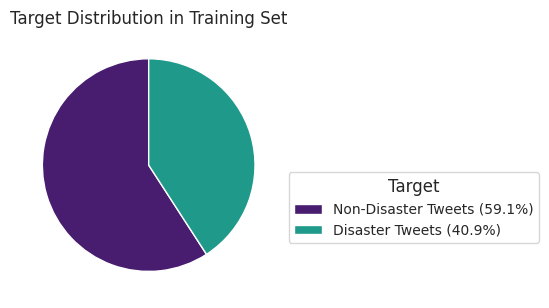

In [42]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)  # Use subplots() to get the Axes object
plt.tight_layout(pad=3.0)  # Add padding around the plot

# Calculate target counts and percentages
target_counts = df['target'].value_counts()
total_count = target_counts.sum()
labels = [f'Non-Disaster Tweets ({target_counts[0]/total_count:.1%})',
         f'Disaster Tweets ({target_counts[1]/total_count:.1%})']

# Define colors from the viridis palette
colors = [palette[0], palette[6]]  # Assign specific colors to each slice

# Plot pie chart for target distribution with customized colors
wedges, texts, autotexts = ax.pie(target_counts, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(edgecolor='white'))

# Set the title
ax.set_title('Target Distribution in Training Set')

# Remove the default labels (texts)
for text in texts:
    text.set_visible(False)
for autotext in autotexts:
    autotext.set_visible(False)

# Add a legend with a specific location and size
ax.legend(wedges, labels, title='Target', loc='best', bbox_to_anchor=(1, 0.5), fontsize='small')

# Display the plot
plt.show()

**Observaciones 💡 -->**

> - Como es posible observar, nuestras tablas de frecuencia muestran que el conjunto de datos está desbalanceado en términos de la variable 'target': el **valor 0** (que indica la ausencia de un desastre) aparece con mucha más frecuencia (4105 casos) que el **valor 1** (que indica la presencia de un desastre) con 2835 casos. Este desbalance podría afectar el rendimiento de nuestro modelo pero primero evaluaremos su desempeño antes de tomar decisiones.

> -  Para la columna keyword, esta simple tabla de frecuencia no nos dice lo suficiente así que haremos un análisis más profundo.

In [19]:
# Pairing 0's with their most frequent keywords
target_0_keywords = df[df['target'] == 0]['keyword'].value_counts().head(10)
print("Top 10 most frequent keywords for target '0':")
for index, (keyword, frequency) in enumerate(target_0_keywords.items(), start=1):
    print(f"{index:<5} {keyword:<30} {frequency:<10}")
print("\n===============================================")

# Pairing 1's with their most frequent keywords
target_1_keywords = df[df['target'] == 1]['keyword'].value_counts().head(10)
print("Top 10 most frequent keywords for target '1':")
for index, (keyword, frequency) in enumerate(target_1_keywords.items(), start=1):
    print(f"{index:<5} {keyword:<30} {frequency:<10}")

Top 10 most frequent keywords for target '0':
1     body%20bags                    39        
2     harm                           37        
3     armageddon                     37        
4     deluge                         36        
5     ruin                           36        
6     wrecked                        36        
7     twister                        35        
8     fear                           35        
9     siren                          35        
10    panic                          34        

Top 10 most frequent keywords for target '1':
1     evacuated                      31        
2     debris                         31        
3     earthquake                     30        
4     derailment                     29        
5     wildfire                       29        
6     nuclear%20disaster             28        
7     suicide%20bombing              28        
8     evacuation                     28        
9     buildings%20on%20fire          27    

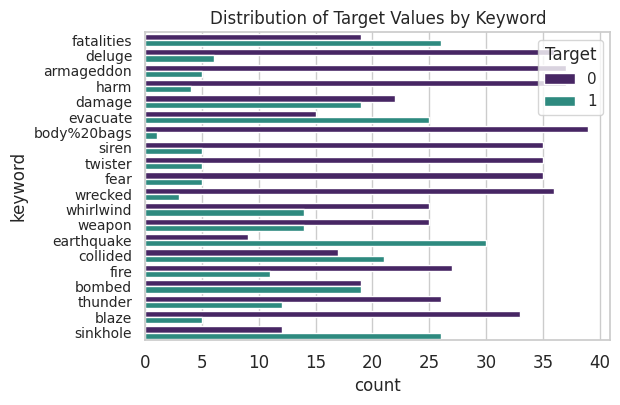

In [45]:
# Create a figure with increased size for better visual clarity
fig = plt.figure(figsize=(6, 4), dpi=100)  # Adjusted figsize for better visual clarity

# Group by 'keyword' and calculate mean target values
grouped_df = df.groupby('keyword')['target'].transform('mean')

# Sort DataFrame by calculated mean target values
sorted_df = df.assign(mean_target=grouped_df).sort_values(by='mean_target', ascending=False)

# Optional: Display only the top N keywords for better visibility
top_n = 20
top_keywords = sorted_df['keyword'].value_counts().index[:top_n]
filtered_df = sorted_df[sorted_df['keyword'].isin(top_keywords)]

# Create a count plot with horizontal bars
sns.countplot(y='keyword', hue='target', data=filtered_df, order=top_keywords, palette=colors)

# Customize plot appearance
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.legend(title='Target', loc='upper right')
plt.title('Distribution of Target Values by Keyword')

# Display the plot
plt.show()

**Observaciones 💡 -->**

> - Se evidencia que para el target 0, los términos más frecuentes como "body bags" "harm" y "armageddon" están relacionados con eventos graves o de alta magnitud, pero en el contexto de la ausencia de un desastre, estos podrían estar mal clasificados o reflejar un contexto de preocupación general. Por otro lado, para el target 1, palabras como "evacuated" "debris" y "earthquake" se relacionan claramente con eventos de emergencia reales.

> - En general, los bigramas o trigramas consisten en obtener los tokens o palabras consecutivas. Esta técnica está más orientadas a aplicaciones como el análisis de sentimientos o la predicción de texto, pero se considera que podría llegar a aplicarse en este contexto. Para esto, no obstante, primero es importante adquirir ¡aún más información acerca de nuestro conjunto de datos! [[Referencia]](https://www.geeksforgeeks.org/generate-bigrams-with-nltk/)

#### **(3) Análisis Visual Preliminar de los Datos**

In [21]:
# Converting the column to a list
column_to_list = df['keyword'].unique().tolist()
# Convert all elements to strings to avoid TypeError
column_to_list_str = [str(keyword) for keyword in column_to_list]
print(f"\nNumber of unique values in keyword = {len(column_to_list_str)}")


Number of unique values in keyword = 221


##### **(1) Generación de Bigramas**

##### **(1) Generación de Trigramas**